In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

/Users/piyushpandita/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


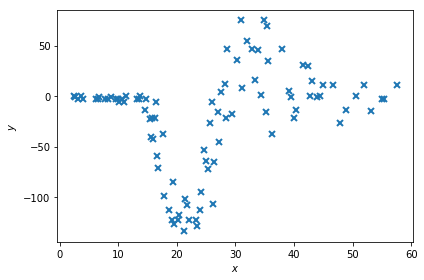

In [2]:
data = np.loadtxt('../data/motor.dat')
X = data[:, 0][:, None]
Xm = np.mean(X)
Xv = np.std(X)
Xnorm = (X - Xm)/Xv
Y = data[:, 1]
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [3]:
#build the model
k1 = gpflow.kernels.RBF(1)
k2 = gpflow.kernels.RBF(1)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
m = hetero_gpmc.GPMCAdaptLAdaptN(Xnorm, Y[:,None], k1, k2, nonstat)

In [4]:
m

Name,values,prior,constraint
adapt_ll_noise_gps.V1,[[0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.]],"N([0.],[1.])",(none)
adapt_ll_noise_gps.V2,[[0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.]],"N([0.],[1.])",(none)
adapt_ll_noise_gps.V3,[[0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.]],"N([0.],[1.])",(none)
adapt_ll_noise_gps.kern1.lengthscales,[1.],None,+ve
adapt_ll_noise_gps.kern1.variance,[1.],None,+ve
adapt_ll_noise_gps.kern2.lengthscales,[1.],None,+ve
adapt_ll_noise_gps.kern2.variance,[1.],None,+ve
adapt_ll_noise_gps.nonstat.signal_variance,[1.],None,+ve
adapt_ll_noise_gps.signal_variance,[1.],None,+ve


In [5]:
#m.kern1.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern1.variance = 0.1
m.kern1.variance.fixed = True
m.kern1.variance.prior = gpflow.priors.Gamma(1., 1.)

m.kern2.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
#m.kern2.variance.prior = gpflow.priors.Gamma(1., 1.)
m.kern2.variance = 0.1
m.kern2.variance.fixed = True

m.nonstat.signal_variance = 100
m.nonstat.signal_variance.fixed = True

In [6]:
m.optimize(maxiter=5000)

      fun: array([775.22460878])
 hess_inv: <285x285 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.71015587e-03,  5.45780775e-05,  2.55333489e-04,  4.79851647e-04,
        3.00490998e-04,  4.15656367e-04,  1.09500683e-04,  2.95979572e-04,
        2.98117954e-04,  3.10022122e-04,  3.74557714e-04,  5.17497794e-04,
        1.19138518e-04,  2.84513099e-04,  4.12327051e-04, -1.88226001e-04,
        3.85910668e-04, -5.19581893e-05,  1.20661930e-03, -1.06886411e-03,
       -8.71430139e-04,  9.15626658e-04, -2.10456042e-04, -2.59097068e-05,
        8.64715507e-05, -9.63744923e-05, -9.62198717e-05, -6.03708425e-05,
       -2.64481635e-05, -2.73900200e-06, -5.03379862e-05, -4.84397443e-05,
       -5.05394151e-05, -5.00511262e-05, -4.04288295e-05, -2.53505798e-05,
       -1.68852426e-05, -2.52002375e-05, -8.75760461e-06, -1.39515198e-05,
       -3.66730444e-06,  4.06155444e-06,  9.43994255e-06,  2.92483929e-06,
        6.81949461e-06,  1.61843761e-05,  8.89717244e-06,  1.62206834e-

In [39]:
samples = m.sample(20, verbose=True, epsilon=0.01, thin = 2, burn = 100, Lmax = 40)

burn-in sampling started
Iteration:  100 	 Acc Rate:  98.0 %
burn-in sampling ended


In [74]:
print samples.shape

(285, 1)


In [44]:
Xnorm.shape
sample = m.optimize(maxiter=500)
samples = sample.x[:, None]

In [45]:
print samples.shape
print X.shape[0]

(285, 1)
94


In [47]:
sample_df = m.get_samples_df(samples.T)

In [48]:
mean_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

In [49]:
xnew = np.linspace(0, 60, 50)[:,None]
xx = (xnew - Xm) / Xv

In [50]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_l(xx)
    var1 = v1[:,:]
    mean_l_mat[i,:] = mean1[:,0]
    var_l_mat[i,:] = np.diag(var1)

std_l_mat = np.sqrt(var_l_mat)

In [51]:
LowerlogL = mean_l_mat - 2*std_l_mat
UpperlogL = mean_l_mat + 2*std_l_mat

In [54]:
MeanL = np.exp(mean_l_mat)
LowerL = np.exp(LowerlogL)
UpperL = np.exp(UpperlogL)

In [55]:
def visualize(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L, U,
                     color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

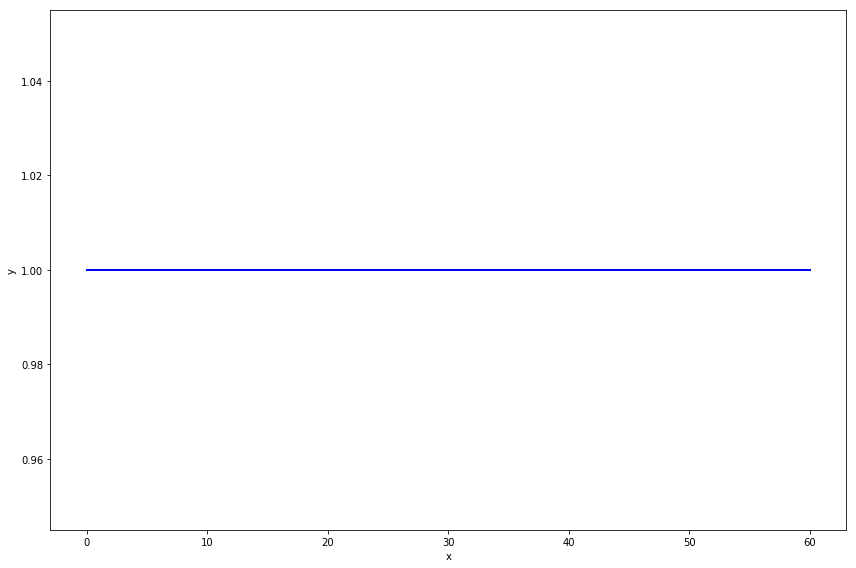

In [56]:
mini = 50
maxi = 110
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(xnew, MeanL[i,:], LowerL[i,:], UpperL[i,:])  

In [57]:
v1.shape

(50, 1)

In [58]:
mean_n_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_n_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

In [59]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_n(xx)
    var1 = v1[:,:]
    mean_n_mat[i,:] = mean1[:,0]
    var_n_mat[i,:] = np.diag(var1)

std_n_mat = np.sqrt(var_n_mat)

In [60]:
LowerlogN = mean_n_mat - 2*std_n_mat
UpperlogN = mean_n_mat + 2*std_n_mat

In [61]:
MeanN = np.exp(mean_n_mat)
LowerN = np.exp(LowerlogN)
UpperN = np.exp(UpperlogN)

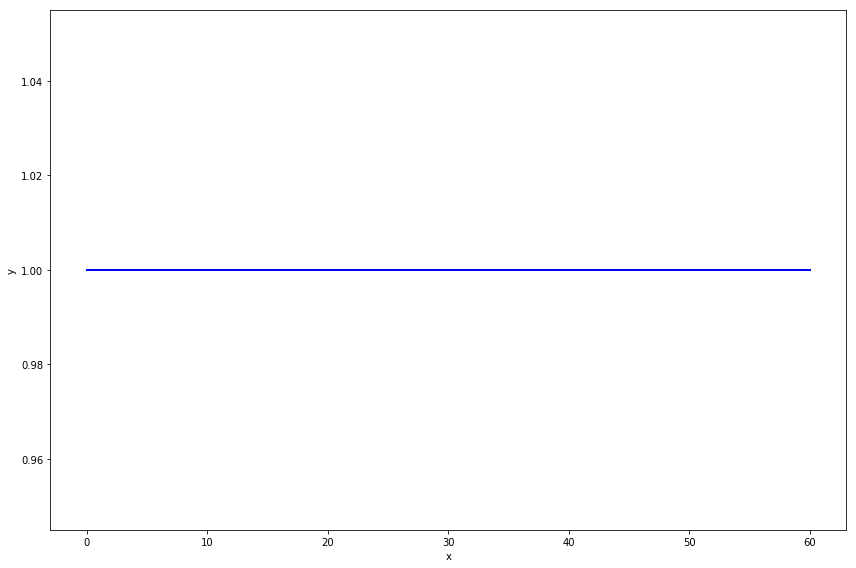

In [62]:
mini = 50
maxi = 151
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(xnew, MeanN[i,:], LowerN[i,:], UpperN[i,:])  

In [65]:
sig_samples = m.signal_variance.get_samples_df(samples.T)
signal_var = np.array([])
for s in sig_samples:
    signal_var = np.append(signal_var, s)

In [66]:
mean_f_mat = np.zeros(shape = (samples.T.shape[0], xx.shape[0]))
var_f_mat = np.zeros(shape = (samples.T.shape[0], xx.shape[0]))

for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_f(xx)
    var1 = v1[:,:,0]
    mean_f_mat[i,:] = mean1[:,0]
    var_f_mat[i,:] = np.diag(var1)    

In [67]:
std_f_mat = np.sqrt(var_f_mat)

In [68]:
Lowerf = mean_f_mat - 2*std_f_mat
Upperf = mean_f_mat + 2*std_f_mat

In [69]:
def visualize_all(Xgrid, M1, L1, U1, U2):
    """
    Visualize
    """  
    L2 = L1 - U2
    U2 = U1 + U2
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, M1, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L1, U1,
                     color = 'b', alpha = 0.25)
    plt.fill_between(Xgrid[:,0], L2, U2,
                     color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

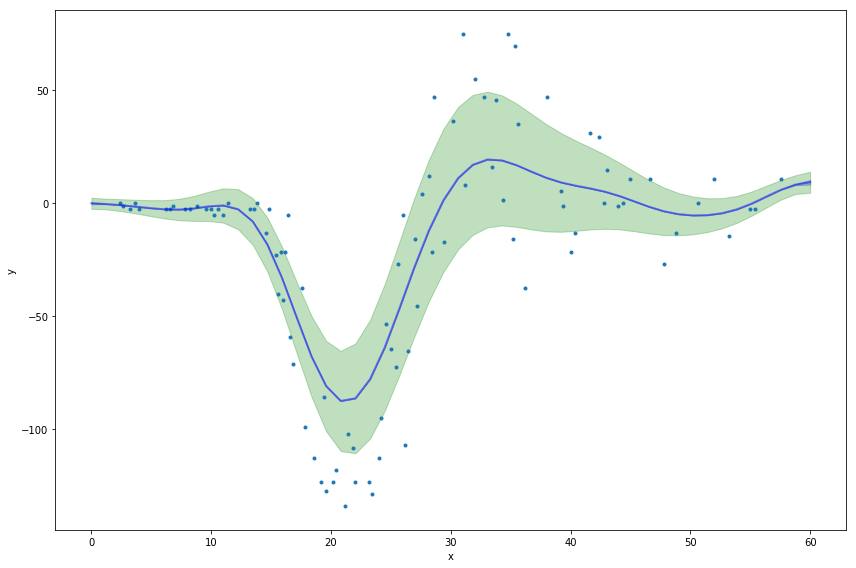

In [71]:
mini = 0
maxi = 1
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_all(xnew, mean_f_mat[i,:],
              Lowerf[i,:], Upperf[i,:],
              UpperN[i,:])